# Visualisation of the NEODYS database for comparison purposes
---

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from packages.dataCleaner import cleanNEODYS

# Cleaning the data file

The raw file contains Optical, Spatial and Radar observations, which are written in the text file using different formats. We need to clean this file in order to work with the data. We split the file into 2 distinct files, suppressing every useless line of data (object header and the position of a satellite in the case of spatial observation)

In [5]:
INPUT_FILE = r'Data\NEODYS_OBS_20200716.txt'
OUTPUT_FILE = r'Data\NEODYS_cleaned.txt'

cleanNEODYS(INPUT_FILE, OUTPUT_FILE)

2735090it [00:16, 169144.75it/s]


# Reading the data

## Optical and Spatial data

Firstly, we give a name to every column (cf documentation), and we read the file, previously separated according to the type of observation.
We start with the optical and spatial observations together in the same Dataframe because they have the same format.

In [6]:

import time as t
start = t.time()
OScolnames = {'object_number': 'category',
              'obs_type': 'category',
              'measure_type': 'category',
              '?': 'category',
              'year': np.uint16,
              'month': np.uint8,
              'day': np.float32,
              'date_accuracy': np.float32,
              'RA_HH': np.uint8,
              'RA_mm': np.uint8,
              'RA_ss': np.float32,
              'RA_accuracy': np.float32,
              'RA_RMS': np.float32,
              #'RA_F': 'category',
              'RA_bias': np.float32,
              'RA_delta': np.float32,
              'DEC_HH': np.uint8,
              'DEC_mm': np.uint8,
              'DEC_ss': np.float32,
              'DEC_accuracy': np.float32,
              'DEC_RMS': np.float32,
              #'DEC_F': 'category',
              'DEC_bias': np.float32,
              'DEC_delta': np.float32,
              'MAG': np.float32,
              'MAG_B': 'category',
              'MAG_RMS': np.float32,
              'MAG_resid': np.float32,
              'catalog': 'category',
              'obs_code': 'category',
              'xhi': np.float32,
              'acceptance': 'bool',
              'mag_acceptance': 'bool'}
c=[(0, 11), (11, 13), (13, 15), (15, 17), (17, 21), (22, 25), (25, 40), (40, 50), (50, 53), (53, 56), (56, 64), (64, 77), (77, 83), (87, 96), (96, 103), (103, 107), (107, 110), (110, 117), (117, 130), (128, 136), (141, 150), (150, 156), (156, 161), (161, 164), (164, 170), (170, 178), (178, 180), (180, 189), (189, 194), (194, 196), (196, 197)]

OSdata = pd.read_fwf(r'Data\NEODYS_cleaned.txt', header=None, names=list(OScolnames.keys()), dtype={'catalog': 'category','obs_code': 'category', 'measure_type': 'category'}, colspecs=c, low_memory=True, index_col=False, usecols=['year', 'RA_RMS', 'RA_delta', 'DEC_RMS', 'DEC_delta', 'MAG', 'catalog', 'obs_code', 'xhi', 'acceptance', 'measure_type'], error_bad_lines=False)
stop = t.time()
print("time : ", stop-start)


time :  158.70976448059082


## Cleaning the catalog names

In [7]:
from packages.catalogCodes import catalog_codes
OSdata = OSdata.replace({'catalog':catalog_codes})
OSdata['catalog'] = OSdata['catalog'].astype('category')

In [8]:
N_CAT = 15
MOST_USED_CATALOGS = list(OSdata['catalog'].value_counts().head(N_CAT).index)
print(MOST_USED_CATALOGS)

['UCAC-4', 'USNO-B1.0', 'USNO-A2.0', 'UCAC-2', 'Gaia-DR2', 'UCAC-3', 'Gaia-DR1', '2MASS', 'PPMXL', 'USNO-SA2.0', 'SST-RC4', 'GSC', 'NOMAD', 'GSC-ACT', 'USNO-A1.0']


We add a new column named `delta_vect` which is the norm of RA_delta and the DEC_delta. 
We do the same for the weight.

We also remove the bad data

In [9]:
OSdata['delta_vect'] = np.sqrt(np.power(OSdata.RA_delta,2) + np.power(OSdata.DEC_delta,2))
OSdata['weight_vect'] = np.sqrt(np.power(OSdata.RA_RMS,2) + np.power(OSdata.DEC_RMS,2))
OSdata = OSdata.drop(OSdata[(OSdata.delta_vect > 20) & (OSdata.acceptance == True)].index)
OSdata = OSdata.drop(OSdata[(OSdata.weight_vect > 20) & (OSdata.acceptance == True)].index)

---
# Most important observatories

Some observatories are publishing a lot more data than others, and so are more reliable. Let's try to visualise which observatories are the most important by ploting the number of observations per observatory.

In [10]:
N_OBS = 20
BEST_OBS_LIST = list(OSdata['obs_code'].value_counts().head(N_OBS).index)

[Text(0, 0.5, 'Total number of observations'),
 Text(0.5, 0, 'Observatory code'),
 Text(0.5, 1.0, 'Number of observations by the 20 most active observatories')]

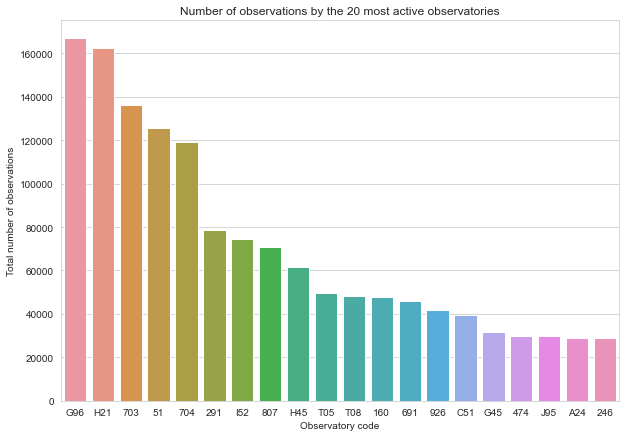

In [11]:
# plot the number of observations for the 20 bigest observatories
plt.figure(figsize=(10,7))
sns.set_style('whitegrid')
ax = sns.countplot(x='obs_code', data=OSdata, order=BEST_OBS_LIST)
ax.set(xlabel='Observatory code', ylabel='Total number of observations', title=f'Number of observations by the {N_OBS} most active observatories')

# Precision over time

With hardware improvements and new software, we can expect the precision of the observations to be better over time. We will verify this assumption for the best observatories.

## Study of the precision weight applied for the fitting process, for best observatories combined

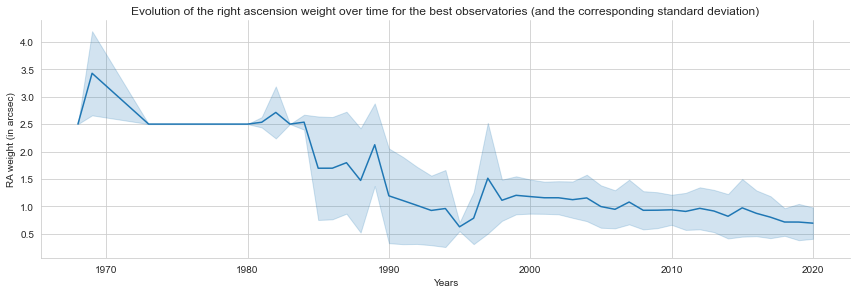

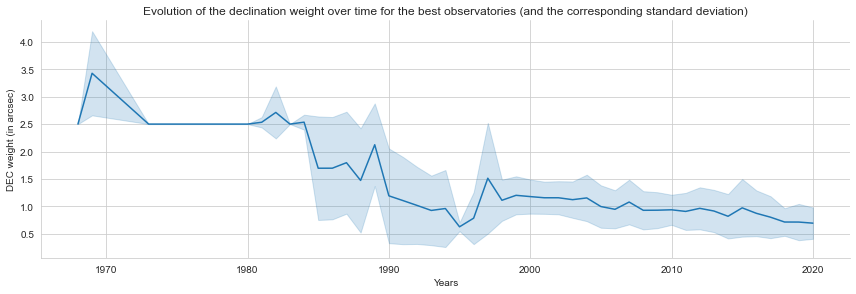

In [12]:
ax = sns.relplot(x='year', y='RA_RMS', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA weight (in arcsec)', title='Evolution of the right ascension weight over time for the best observatories (and the corresponding standard deviation)')

ax = sns.relplot(x='year', y='DEC_RMS', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST) & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC weight (in arcsec)', title='Evolution of the declination weight over time for the best observatories (and the corresponding standard deviation)')


## Evolution of the precision weight over time for the 5 best observatories 

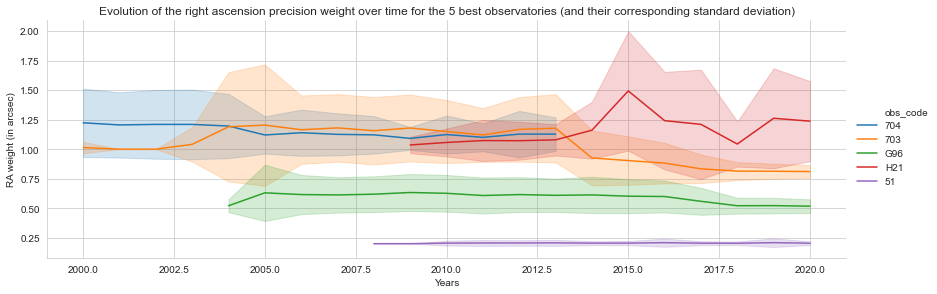

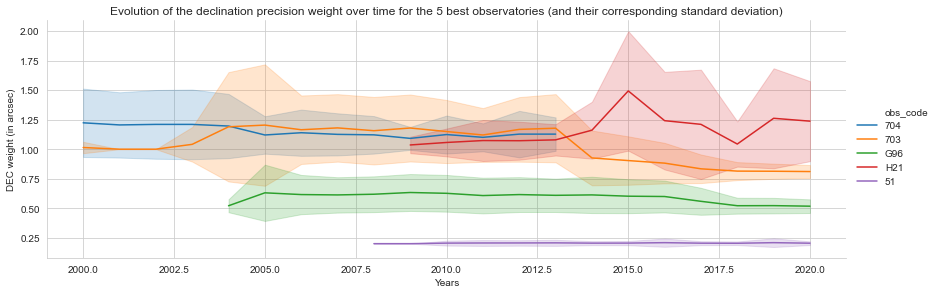

In [13]:
ax = sns.relplot(x='year', y='RA_RMS', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 2000)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA weight (in arcsec)', title='Evolution of the right ascension precision weight over time for the 5 best observatories (and their corresponding standard deviation)')

ax = sns.relplot(x='year', y='DEC_RMS', kind="line", ci="sd", hue='obs_code', 
                 data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST[:5])) & (OSdata['year'] >= 2000)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC weight (in arcsec)', title='Evolution of the declination precision weight over time for the 5 best observatories (and their corresponding standard deviation)')


In [14]:
print("Mean of RA_weight for every catalog (2018-2020): ", OSdata['RA_RMS'][(OSdata['catalog'] != 'Gaia-DR1') & (OSdata['catalog'] != 'Gaia-DR2') & (OSdata['year'] >= 2018)  & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())
print("Mean of RA_weight for GAIA catalogs (2018-2020): ", OSdata['RA_RMS'][(OSdata['catalog'] == 'Gaia-DR1') | (OSdata['catalog'] == 'Gaia-DR2') & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())
print("Mean of RA_weight for non-referenced catalogs (2018-2020): ", OSdata['RA_RMS'][(OSdata['catalog'].isnull()) & (OSdata['year'] >= 2018) & (OSdata['acceptance'] == True) & (OSdata['obs_code'].isin(BEST_OBS_LIST))].mean())

Mean of RA_weight for every catalog (2018-2020):  0.9664841745524214
Mean of RA_weight for GAIA catalogs (2018-2020):  0.6215296440945209
Mean of RA_weight for non-referenced catalogs (2018-2020):  0.7372386223862238


## Study of the RA_Delta and DEC_Delta in function of time

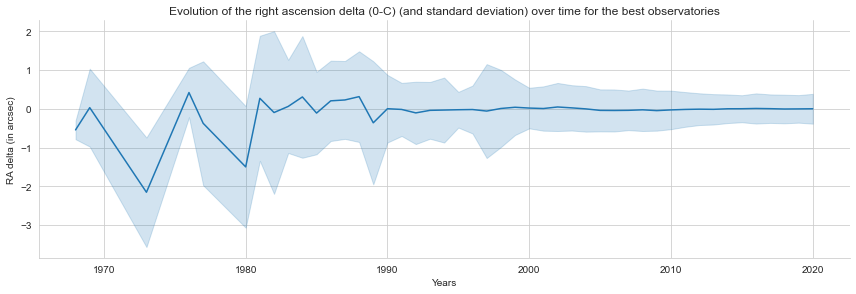

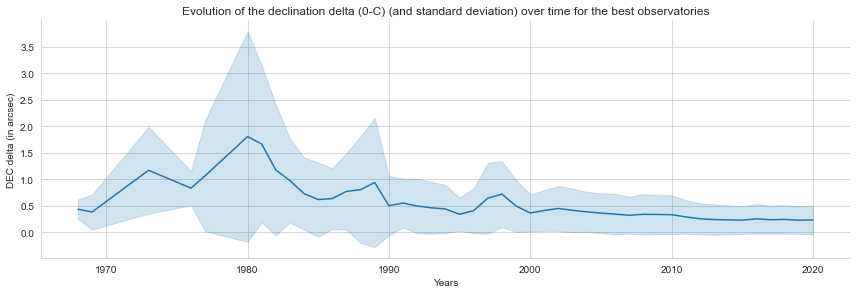

In [15]:
ax = sns.relplot(x='year', y='RA_delta', kind="line", ci="sd", data=OSdata[(OSdata['obs_code'].isin(BEST_OBS_LIST)) & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='RA delta (in arcsec)', title='Evolution of the right ascension delta (0-C) (and standard deviation) over time for the best observatories')

ax = sns.relplot(x='year', y='DEC_delta', kind="line", ci="sd", data=OSdata[OSdata['obs_code'].isin(BEST_OBS_LIST)  & (OSdata['acceptance']==True)], height=4, aspect=3)
ax.set(xlabel='Years', ylabel='DEC delta (in arcsec)', title='Evolution of the declination delta (0-C) (and standard deviation) over time for the best observatories')


# Number of observations per year 

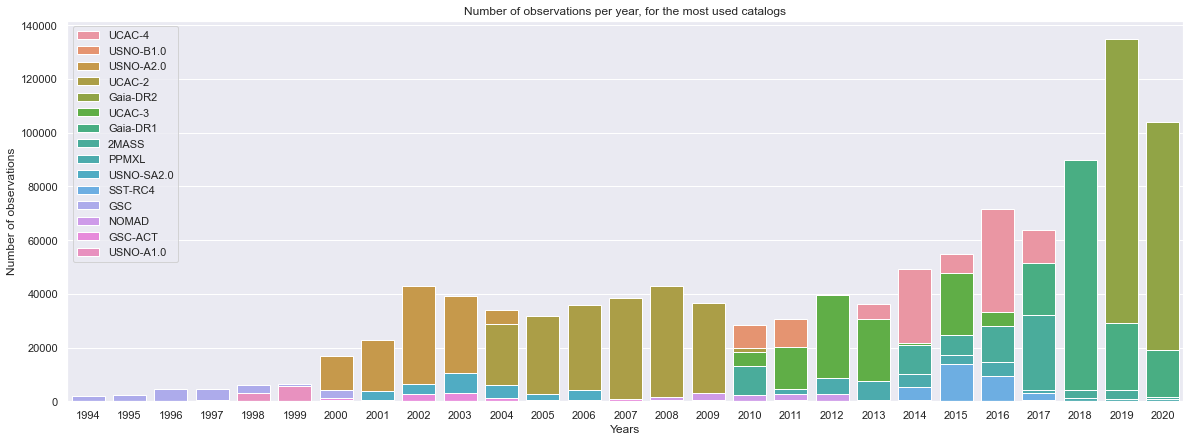

In [16]:
plt.figure(figsize=(20,7))
sns.set(rc={"axes.grid":True})
ax = sns.countplot(x='year', data=OSdata[(OSdata['year'] > 1993) & (OSdata['catalog'].isin(MOST_USED_CATALOGS))], hue='catalog', hue_order=MOST_USED_CATALOGS, dodge=False)
ax.set(xlabel='Years', ylabel='Number of observations', title='Number of observations per year, for the most used catalogs')
plt.legend(loc='upper left')

As we can see on the previous graph, the introduction of the GAIA star catalogs in 2017 for Gaia-DR1 and 2018 for Gaia-DR2 is very noticable. Those two catalogs became the norm due to their very high precison, with only a few observations associated with UCAC-3 which was the most used catalog in the 2010s. In 6 months, 2020 already gathered more observations than the full year of 2018.

The very high number of observations made with the Gaia catalogs should result in an increase in precision.

# Precision of the Star Catalogs



Here we compute the mean, median and standard deviation of the `delta_vect` data for each catalog.

In [17]:
stats = pd.DataFrame(index=MOST_USED_CATALOGS, columns=['mean', 'std', 'median', 'count'])
for catalog in MOST_USED_CATALOGS:
    mean = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == True)].delta_vect.mean()
    std = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].delta_vect.std()
    median = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].delta_vect.median()
    count = len(OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].index)
    stats.loc[catalog] = pd.Series({'mean': mean, 'std': std, 'median': median, 'count': count})
stats

mean       std    median   count
UCAC-4      0.486011  0.445499  0.356808  329466
USNO-B1.0   0.454044  0.407886  0.339175  321966
USNO-A2.0   0.620495  0.500885  0.486901  297329
UCAC-2       0.53302  0.480469  0.392256  294540
Gaia-DR2    0.401202  0.395181  0.288141  292442
UCAC-3      0.386569  0.355098  0.287939  269282
Gaia-DR1    0.317354  0.330691  0.211021  192678
2MASS       0.318708  0.378563  0.183306  144191
PPMXL         0.3311   0.36919  0.216539   71218
USNO-SA2.0  0.654942  0.552133  0.497397   40776
SST-RC4     0.374547  0.269659  0.310846   31727
GSC         0.815477  0.609446  0.661713   30987
NOMAD        0.39863  0.413952  0.281991   14924
GSC-ACT     0.663576  0.556695  0.504914   13639
USNO-A1.0   0.854304   0.69518  0.663528   11697

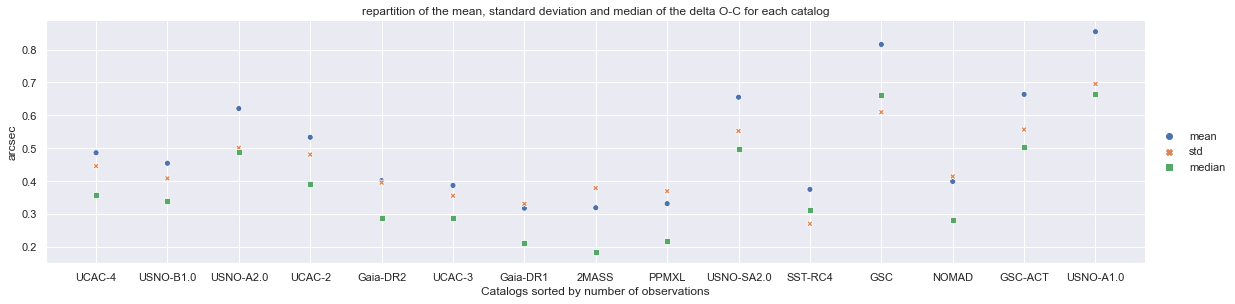

In [18]:
ax = sns.relplot(data=stats.drop(['count'], axis=1), height=4, aspect=4)
ax.set(xlabel='Catalogs sorted by number of observations', ylabel='arcsec',
       title='repartition of the mean, standard deviation and median of the delta O-C for each catalog')

## Precision weight in function of the star catalog

In [19]:
weight_stats = pd.DataFrame(index=MOST_USED_CATALOGS, columns=['mean', 'std', 'median', 'count'])
for catalog in MOST_USED_CATALOGS:
    mean = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].weight_vect.mean()
    std = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].weight_vect.std()
    median = OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].weight_vect.median()
    count = len(OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].index)
    weight_stats.loc[catalog] = pd.Series({'mean': mean, 'std': std, 'median': median, 'count': count})
weight_stats

mean       std    median   count
UCAC-4       1.62303   1.26336   1.41421  329466
USNO-B1.0    1.36838  0.990821   1.41421  321966
USNO-A2.0    1.61385   0.70273   1.41421  297329
UCAC-2       1.53267   0.74167   1.41421  294540
Gaia-DR2    0.966271  0.454865  0.848528  292442
UCAC-3       1.89918   1.41279   1.41421  269282
Gaia-DR1    0.822861  0.510063  0.848528  192678
2MASS       0.800635  0.711686  0.374767  144191
PPMXL        1.18075  0.850617   1.41421   71218
USNO-SA2.0   1.49196  0.747278   1.41421   40776
SST-RC4      1.08372  0.195936   1.03945   31727
GSC          1.56418  0.472537   1.41421   30987
NOMAD        1.56835  0.458502   1.41421   14924
GSC-ACT      2.26904   1.87914   1.41421   13639
USNO-A1.0    1.66328  0.462483   1.58109   11697

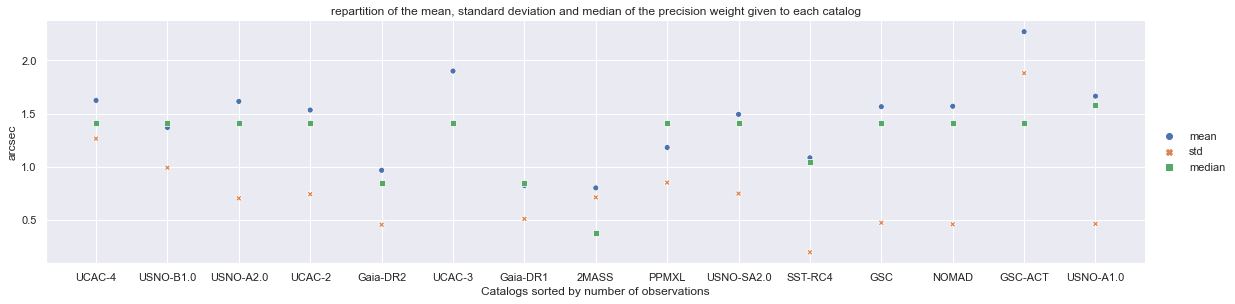

In [20]:
ax = sns.relplot(data=weight_stats.drop(['count'], axis=1), height=4, aspect=4)
ax.set(xlabel='Catalogs sorted by number of observations', ylabel='arcsec',
       title='repartition of the mean, standard deviation and median of the precision weight given to each catalog')

## Xhi square

Xhi square is calculated as : ((O-C)/weight)^2

If it is too close to zero, the weightmay be too high. If it is too far to zero, the weight may be too low. This also varies with the delta (O-C) of the observations.

### By catalog

In [31]:
xhi_df = pd.DataFrame(index=MOST_USED_CATALOGS, columns=['xhi_2', 'std'])
for catalog in MOST_USED_CATALOGS:
    xhi_2 = np.power(OSdata[(OSdata['catalog'] == catalog) & (OSdata['acceptance'] == 1)].xhi,2).mean()
    xhi_2_std = np.power(OSdata[(OSdata['obs_code'] == catalog) & (OSdata['acceptance'] == 1)].xhi, 2).std()
    xhi_df.loc[catalog] = pd.Series({'xhi_2': xhi_2, 'std': xhi_2_std})

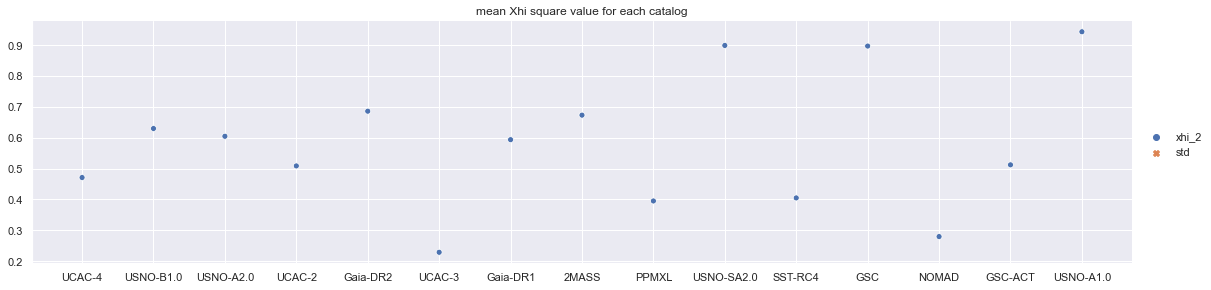

In [32]:
ax = sns.relplot(data=xhi_df, height=4, aspect=4)
ax.set(title="mean Xhi square value for each catalog")


### By observatory

In [23]:
xhi_df = pd.DataFrame(index=BEST_OBS_LIST, columns=['xhi_2', 'std'])
for obs in BEST_OBS_LIST:
    xhi_2 = np.power(OSdata[(OSdata['obs_code'] == obs) & (OSdata['acceptance'] == 1)].xhi, 2).mean()
    xhi_2_std = np.power(OSdata[(OSdata['obs_code'] == obs) & (OSdata['acceptance'] == 1)].xhi, 2).std()
    xhi_df.loc[obs] = pd.Series({'xhi_2': xhi_2, 'std': xhi_2_std})

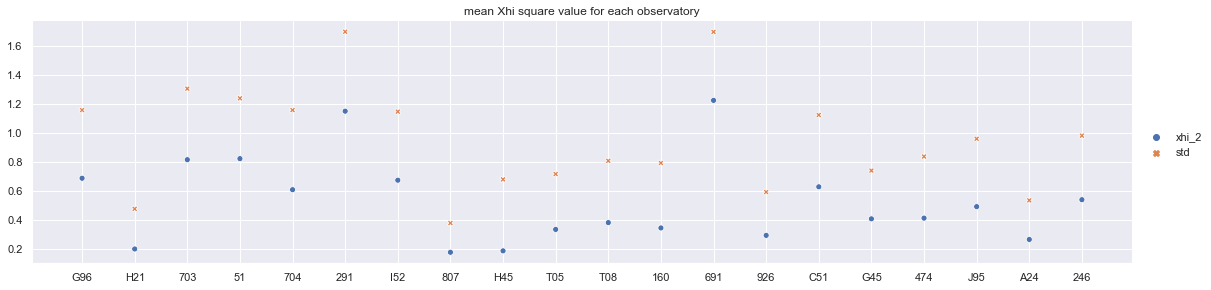

In [24]:
ax = sns.relplot(data=xhi_df, height=4, aspect=4)
ax.set(title="mean Xhi square value for each observatory")

# Influence of Magnitude on precision of observations.

## By observatory 

In [25]:
sample_obs = OSdata[(OSdata['delta_vect']<=4) & (OSdata.obs_code.isin(BEST_OBS_LIST[:6]))].sample(10000)


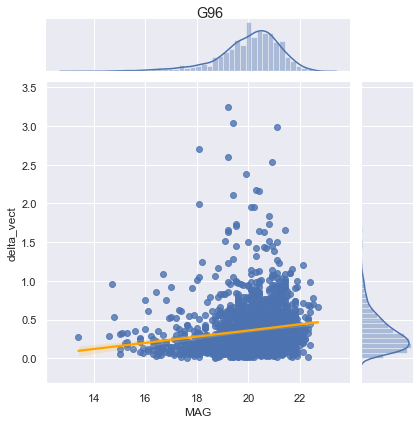

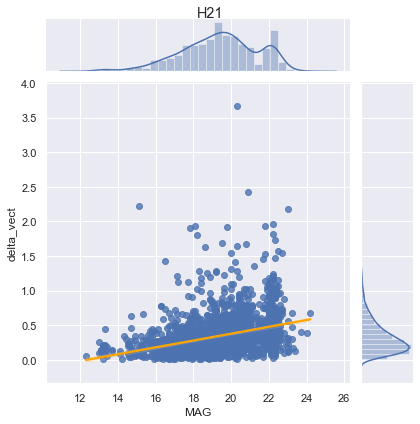

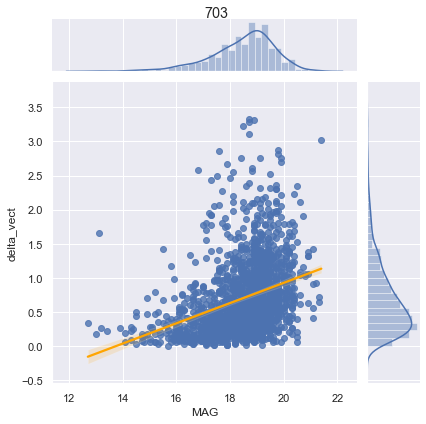

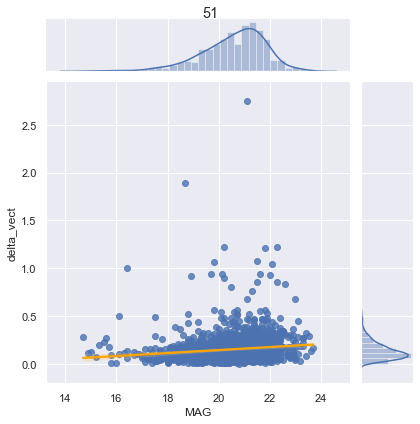

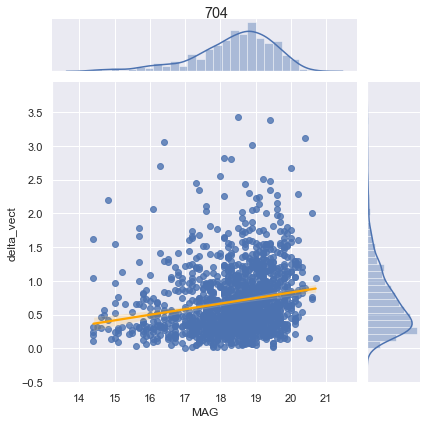

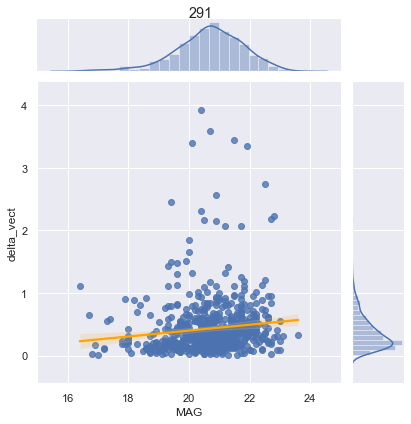

In [26]:
for obs in BEST_OBS_LIST[:6]:
    ax = sns.jointplot(x='MAG', y='delta_vect', data=sample_obs[sample_obs.obs_code==obs], kind='reg', line_kws={'color':'orange'})
    ax.fig.suptitle(obs)
    ax.fig.subplots_adjust(top=0.95) 

## By catalog

In [27]:
sample_cat = OSdata[(OSdata['delta_vect']<=4) & (OSdata.catalog.isin(MOST_USED_CATALOGS[:6])) & (OSdata.MAG >= 14)].sample(10000)

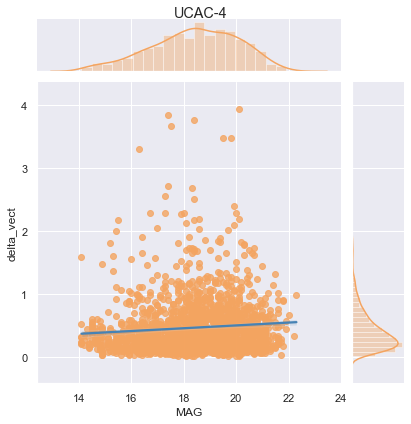

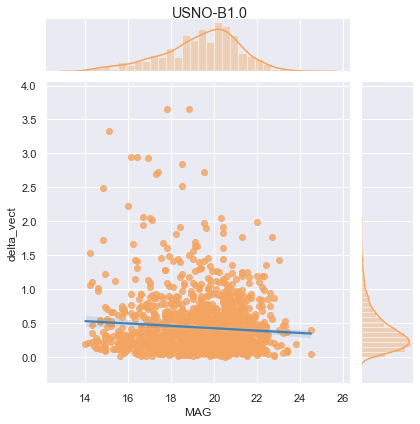

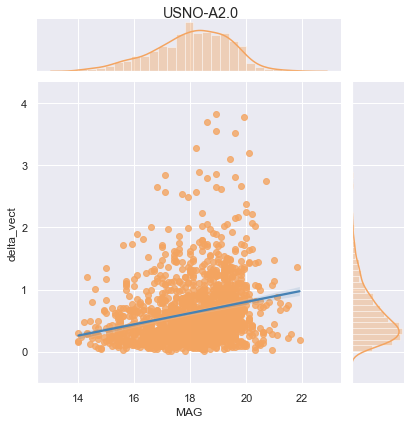

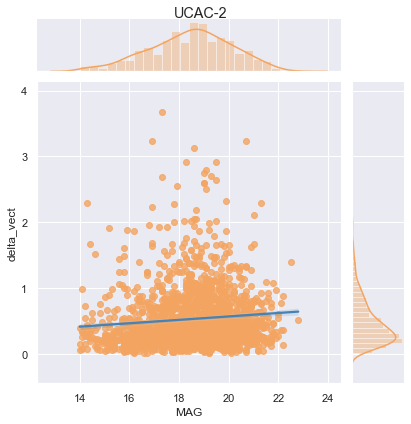

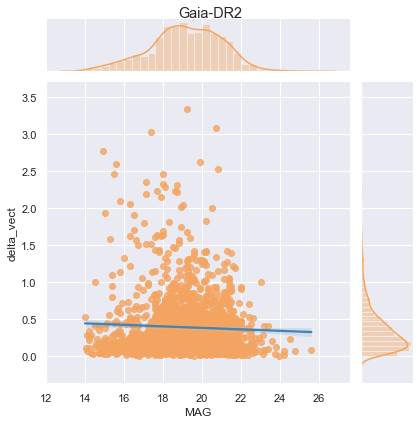

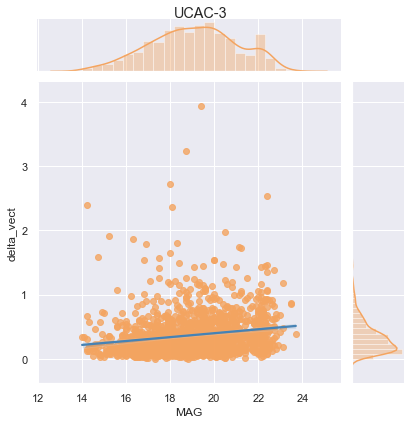

In [28]:
for cat in MOST_USED_CATALOGS[:6]:
    ax = sns.jointplot(x='MAG', y='delta_vect', data=sample_cat[sample_cat.catalog==cat], kind='reg', color='sandybrown', line_kws={'color':'steelblue'})
    ax.fig.suptitle(cat)
    ax.fig.subplots_adjust(top=0.95)

# Catalog repartition per observatory

The goal of this section is to find which catalogs are used by the biggest observatories.

In [29]:
l_cat = []
for cat in MOST_USED_CATALOGS:
    l_obs = []
    for obs in BEST_OBS_LIST:
        l_obs.append(len(OSdata[(OSdata['obs_code']==obs) & (OSdata['catalog']==cat)]))
    l_cat.append(l_obs)
l_cat = np.array(l_cat)


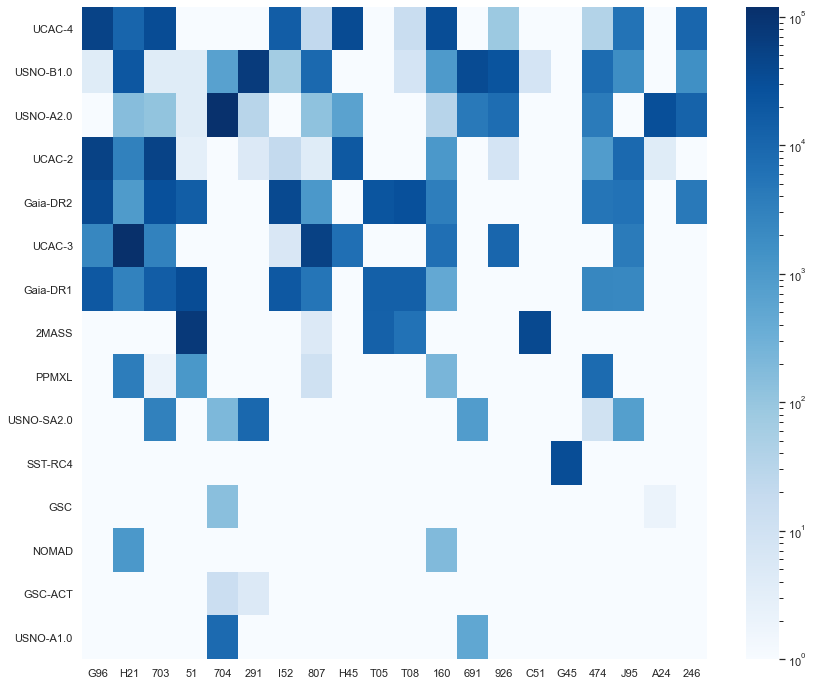

In [30]:
plt.figure(figsize=(14,12))
ax = sns.heatmap(np.maximum(l_cat, 1), annot=False, cmap='Blues', norm=LogNorm(), yticklabels=MOST_USED_CATALOGS, xticklabels=BEST_OBS_LIST)